In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [2]:
modes = ['EASIER', 'ENLIGHT', 'IRnet'] #, 'COMPASS'
colors = sns.color_palette('gnuplot_r', len(modes))
colors.append('#36AFCE')
colors

[(0.8654591890107455, 0.42022274992272957, 0.0),
 (0.7057189353321013, 0.12353517123881463, 0.012319659535238529),
 (0.4970501217477084, 0.01507999185833503, 0.9998292504580527),
 '#36AFCE']

In [3]:
dfc = pd.read_csv('../../../00_data/BLCA/IMVigor210_clinical.tsv',sep = '\t', index_col=0)

In [4]:
df1 = pd.read_csv('IMVigor210_EASIER_score.csv',index_col=0)
#df2 = pd.read_csv('IMVigor210_EASIER_score.csv',index_col=0)
df3 = pd.read_csv('IMVigor210_COMPASS_score.csv',index_col=0)
df4 = pd.read_csv('IMVigor210_IRnet_score.csv',index_col=0)

In [5]:
df = dfc.join(df1).join(df3).join(df4)

In [6]:
dfp = df[['response_label', 'EASIER', 'IRnet',
           'COMPASS_score_42','COMPASS_score_64','COMPASS_score_24',]] #, 'ENLIGHT', 

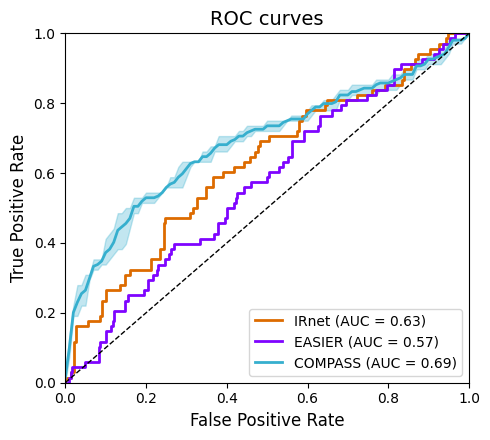

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 映射标签
y_true = df['response_label'].map({'R': 1, 'NR': 0})

# 分数列
easier_score = df['EASIER']
#nlight_score = df['ENLIGHT']
irnet_score = df['IRnet']
pft_scores = df[['COMPASS_score_24', 'COMPASS_score_42', 'COMPASS_score_64']]

# 基准 FPR
base_fpr = np.linspace(0, 1, 101)

# 插值 TPR
def get_interp_tpr(y_true, y_score, base_fpr):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return np.interp(base_fpr, fpr, tpr)

# PFT TPR 插值 + 平均
pft_tprs = np.vstack([
    get_interp_tpr(y_true, pft_scores[col], base_fpr)
    for col in pft_scores.columns
])
pft_mean_tpr = pft_tprs.mean(axis=0)
pft_auc = auc(base_fpr, pft_mean_tpr)

# 使用 plt.subplots 创建图和轴
fig, ax = plt.subplots(figsize=(5, 4.5))

# irnet_score
fpr_n, tpr_n, _ = roc_curve(y_true, irnet_score)
auc_n = auc(fpr_n, tpr_n)
ax.plot(fpr_n, tpr_n, label=f'IRnet (AUC = {auc_n:.2f})', lw=2, color=colors[0])


# # ENLIGHT
# fpr_n, tpr_n, _ = roc_curve(y_true, enlight_score)
# auc_n = auc(fpr_n, tpr_n)
# ax.plot(fpr_n, tpr_n, label=f'ENLIGHT (AUC = {auc_n:.2f})', lw=2, color=colors[1])


# EASIER
fpr_e, tpr_e, _ = roc_curve(y_true, easier_score)
auc_e = auc(fpr_e, tpr_e)
ax.plot(fpr_e, tpr_e, label=f'EASIER (AUC = {auc_e:.2f})', lw=2, color=colors[2])


ax.plot(base_fpr, pft_mean_tpr, label=f'COMPASS (AUC = {pft_auc:.2f})', lw=2, color=colors[3])
ax.fill_between(base_fpr, pft_tprs.min(axis=0), pft_tprs.max(axis=0),
                color=colors[3], alpha=0.3)


ax.plot([0, 1], [0, 1], 'k--', lw=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC curves', fontsize=14)
ax.legend(loc='lower right', fontsize=10, frameon=True, facecolor='white')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.tight_layout()
plt.savefig('./results/IMVigor210_roc.pdf', bbox_inches='tight')

/tmp/ipykernel_337392/764060745.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [positive_rate, positive_rate], 'k--', color='gray', lw=1, label='Random baseline')


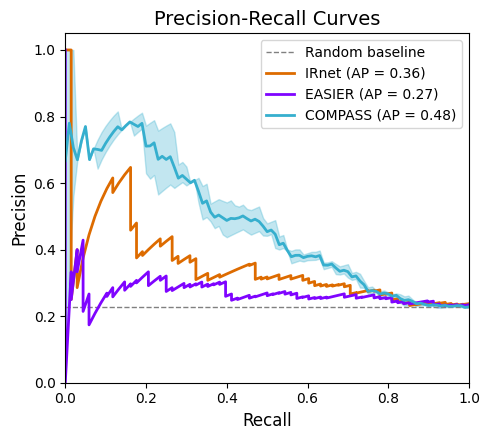

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 创建子图
fig, ax = plt.subplots(figsize=(5, 4.5))

positive_rate = y_true.mean()
ax.plot([0, 1], [positive_rate, positive_rate], 'k--', color='gray', lw=1, label='Random baseline')


# IRnet
precision_n, recall_n, _ = precision_recall_curve(y_true, irnet_score)
ap_n = average_precision_score(y_true, irnet_score)
ax.plot(recall_n, precision_n, label=f'IRnet (AP = {ap_n:.2f})', lw=2, color=colors[0])


# # ENLIGHT
# precision_n, recall_n, _ = precision_recall_curve(y_true, enlight_score)
# ap_n = average_precision_score(y_true, enlight_score)
# ax.plot(recall_n, precision_n, label=f'ENLIGHT (AP = {ap_n:.2f})', lw=2, color=colors[1])

# EASIER
precision_e, recall_e, _ = precision_recall_curve(y_true, easier_score)
ap_e = average_precision_score(y_true, easier_score)
ax.plot(recall_e, precision_e, label=f'EASIER (AP = {ap_e:.2f})', lw=2, color=colors[2])

pft_precisions = []
pft_recalls = []


base_recall = np.linspace(0, 1, 101)
for col in pft_scores.columns:
    precision, recall, _ = precision_recall_curve(y_true, pft_scores[col])
    precision_interp = np.interp(base_recall, recall[::-1], precision[::-1])
    pft_precisions.append(precision_interp)
    pft_recalls.append(base_recall)

pft_precisions = np.vstack(pft_precisions)
pft_mean_precision = pft_precisions.mean(axis=0)
ap_pft = average_precision_score(y_true, pft_scores.mean(axis=1))


ax.plot(base_recall, pft_mean_precision, label=f'COMPASS (AP = {ap_pft:.2f})', lw=2, color=colors[3])
ax.fill_between(base_recall, pft_precisions.min(axis=0), pft_precisions.max(axis=0),
                color=colors[3], alpha=0.3)

# 图形美化
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves', fontsize=14)
ax.legend(loc='best', fontsize=10, frameon=True, facecolor='white')
ax.set_xlim([0, 1])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()

plt.savefig('./results/IMVigor210_prc.pdf', bbox_inches='tight')

/tmp/ipykernel_337392/2328450946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['COMPASS'] = dfp[['COMPASS_score_42', 'COMPASS_score_24', 'COMPASS_score_64']].mean(axis=1)


<Axes: >

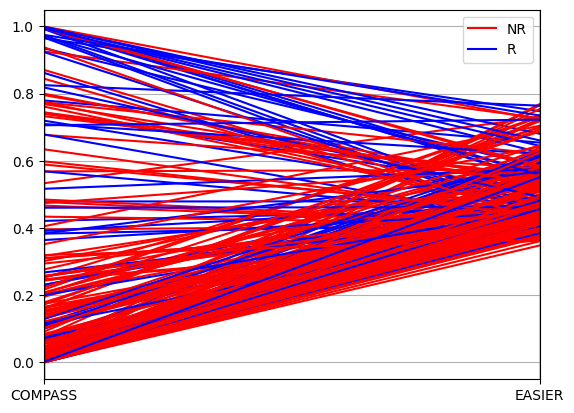

In [11]:
dfp['COMPASS'] = dfp[['COMPASS_score_42', 'COMPASS_score_24', 'COMPASS_score_64']].mean(axis=1)
pd.plotting.parallel_coordinates(dfp, class_column='response_label',color = ['r', 'b'], 
                                 cols=['COMPASS', 'EASIER' ]) #'EASIER', 'IRnet', 